In [1]:
import config
import engine
import dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot
import pickle as pkl

import functools
import torch.nn as nn
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from scipy.special import softmax

DEVICE = "cuda"

# Specify location of models
category_model_path = 'models/category3000-len64_batch16.bin'
fake_model_path = 'models/ieee_clipped-len512_batch2.bin'

# Read label dictionaries that were instantiated during training of our two models, 
# making the labels readable for humans
with open('../input/news_category3000_label_dict.pkl', 'rb') as handle:
    news_category_dict = pkl.load(handle)
    
with open('../input/ieee_clipped_label_dict.pkl', 'rb') as handle:
    news_fake_dict = pkl.load(handle)

#### Read all the csv files we are testing on and put them into a dataframe

In [2]:
articles = [pd.read_csv('../input/all_the_news/articles{}.csv'.format(i), index_col=0) for i in range(1,4)]
all_the_news = pd.concat(articles, ignore_index=True)

#### Here we see the distribution of publications for all our test data

142570


<AxesSubplot:>

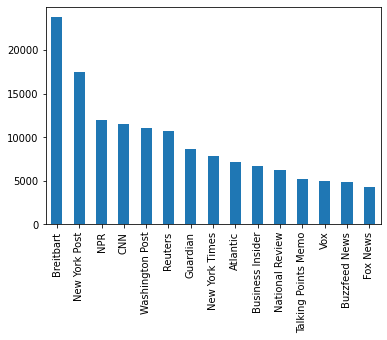

In [3]:
print(len(all_the_news))
all_the_news['publication'].value_counts().plot(kind='bar')

#### Perform the exact same data cleaning as done with the training data

In [4]:
all_the_news['content'] = all_the_news['content'].replace('\n',' ', regex=True)
all_the_news['content'] = all_the_news['content'].replace('\t',' ', regex=True)
all_the_news['content'] = all_the_news['content'].replace('\r',' ', regex=True)
all_the_news['content'] = all_the_news['content'].str.replace('"', '')

all_the_news['title'] = all_the_news['title'].replace('\n',' ', regex=True)
all_the_news['title'] = all_the_news['title'].replace('\t',' ', regex=True)
all_the_news['title'] = all_the_news['title'].replace('\r',' ', regex=True)
all_the_news['title'] = all_the_news['title'].str.replace('"', '')

all_the_news['content'] = all_the_news['content'].astype(str)
all_the_news['title'] = all_the_news['title'].astype(str)

#### Filter out all articles with word length bigger than 512, the token boundary of BERT. Then show the publication distribution.

In [5]:
all_the_news['word_length'] = all_the_news['content'].apply(lambda x: len(x.split(" ")))
all_the_news = all_the_news[all_the_news['word_length'] < 512]

57120


<AxesSubplot:>

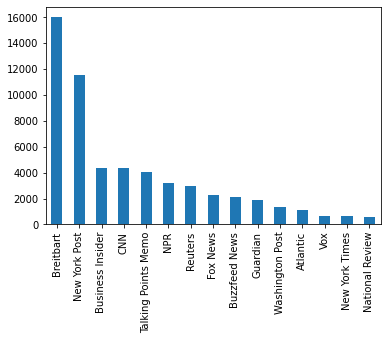

In [6]:
print(len(all_the_news))
all_the_news['publication'].value_counts().plot(kind='bar')

#### Load the model for categorizing the headlines, we use cuda for the classification also, as CPU can run for hours.

In [7]:
# Load BERTForSequenceClassification first with output layer the size of our label dict.
category_model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                               num_labels=len(news_category_dict),
                                                               output_attentions=False,
                                                               output_hidden_states=False)

# Load the finetuned model for categories
category_model.load_state_dict(torch.load(category_model_path, map_location=torch.device(DEVICE)))

category_model.eval()

# Make dataloader according to dataloader.py for headlines only, 
# instantiate with target labels = None and sampler = None 
# dataloader Batch size is read from config, 
# so lower this and import again if you encounter memory problems
dataloader_headlines = dataset.make_dataloader(all_the_news.title.values, None, None)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

57120


#### Run the category model on the headlines from all_the_news

In [8]:
category_model.to(DEVICE)
_, predictions, _ = engine.evaluate(dataloader_headlines, category_model, DEVICE)

100%|██████████| 3570/3570 [04:25<00:00, 13.43it/s]


#### Do a softmax on the result, find the max value, and finally map this max value to a reversed version of the label dict. This will produce the actual predictions from the model

In [9]:
# Do softmax on all outputs
sm_predictions = [softmax(x) for x in predictions]
# Get index of max value
max_preds = [np.argmax(x) for x in sm_predictions]
# Reverse the category dictionary
ivd = {v: k for k, v in news_category_dict.items()}
# Make an array of the predictions
actual_preds = [ivd[x] for x in max_preds]

In [10]:
# Add results to the all_the_news dataframe
all_the_news['predicted_cat'] = actual_preds

#### Load the model for categorizing fake or real news.

In [11]:
# Load BERTForSequenceClassification first with output layer the size of our label dict.
fake_model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                               num_labels=len(news_fake_dict),
                                                               output_attentions=False,
                                                               output_hidden_states=False)

# Load the finetuned model for fake news prediction
fake_model.load_state_dict(torch.load(fake_model_path, map_location=torch.device(DEVICE)))

fake_model.eval()

# Make dataloader according to dataloader.py for article content only, 
# instantiate with target labels = None and sampler = None 
dataloader_content = dataset.make_dataloader(all_the_news.content.values, None, None)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

57120


#### Run the fake news model on the content from all_the_news

In [12]:
fake_model.to(DEVICE)
_, predictions, _ = engine.evaluate(dataloader_content, fake_model, DEVICE)

100%|██████████| 3570/3570 [04:19<00:00, 13.74it/s]


#### Do a softmax on the result, find the max value, and finally map this max value to a reversed version of the corresponding label dict. This will produce the actual predictions from the model

In [13]:
sm_predictions = [softmax(x) for x in predictions]
max_preds = [np.argmax(x) for x in sm_predictions]
ivd = {v: k for k, v in news_fake_dict.items()}
actual_preds = [ivd[x] for x in max_preds]

#### Add this result to the final dataframe

In [14]:
all_the_news['fake_real'] = actual_preds

In [15]:
# Show how many fake and real articles the model predicted
all_the_news['fake_real'].value_counts()

fake    29590
real    27530
Name: fake_real, dtype: int64

In [19]:
# Show how many of each category the model predicted
all_the_news['predicted_cat'].value_counts()

POLITICS          25646
THE WORLDPOST      6067
BUSINESS           4944
ENTERTAINMENT      4604
CRIME              3971
SPORTS             2790
TRAVEL             1308
BLACK VOICES       1121
HEALTHY LIVING      902
COMEDY              895
WOMEN               786
STYLE & BEAUTY      748
QUEER VOICES        738
WELLNESS            730
HOME & LIVING       412
PARENTING           355
IMPACT              320
PARENTS             290
FOOD & DRINK        279
WEDDINGS            115
DIVORCE              99
Name: predicted_cat, dtype: int64

In [17]:
# Show value counts of author and fake/real prediction.
all_the_news.value_counts(['publication', 'fake_real'])

publication          fake_real
Breitbart            fake         8612
                     real         7390
New York Post        fake         6054
                     real         5469
CNN                  fake         2674
Business Insider     real         2221
                     fake         2147
Talking Points Memo  fake         2131
Reuters              real         2021
Talking Points Memo  real         1954
NPR                  real         1930
CNN                  real         1684
Fox News             fake         1301
Buzzfeed News        fake         1279
NPR                  fake         1233
Guardian             fake         1024
Fox News             real          967
Reuters              fake          966
Guardian             real          883
Buzzfeed News        real          841
Washington Post      real          745
Atlantic             fake          688
Washington Post      fake          611
Atlantic             real          402
Vox                  real        

In [20]:
all_the_news.to_csv('../output/all_the_news_pred.csv', index=False)